# LSTM Chem - Generate

This notebook will develop a stateful LSTM generative model for creating de novo molecules. It will be fed one input character at a time and iteratively sample the next character until the end character "E" is encountered.


In [ ]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

--2020-07-28 14:26:26--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-07-28 14:26:26--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | done

## Package Plan ##

  environment location: /usr/local

  added / 

In [3]:
# Install RDKit.
%%capture
!pip install rdkit

In [4]:
# import core libraries
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.12.0


In [5]:
# load Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [6]:
# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Fri Jun 23 04:35:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |    387MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [7]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [8]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')

MessageError: ignored

In [9]:
# load the model
model_file = '/content/LSTM_model.h5'
model = load_model(model_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [10]:
# create data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict

In [11]:
# load transfer learning dataset
smifile = '/content/nextgen_smiles.smi'
data = load_data(smifile)
print("Training dataset shape:", data.shape)
print("Sample training smile: \n", data[2])

Training dataset shape: (100,)
Sample training smile: 
 NC1CC(O)C23CCC1C2Cc1c2cc[n+](nc(cnc1C=O)C3)CC1=CC=C(C=C2)N(N)O1


In [12]:
# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/content/char_to_int.json'
d2 = '/content/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [13]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers,
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [14]:
# create our X & y dataset
embed = 101
X_train, y_train = vectorize(data, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)

Training input shape: (100, 100, 45)
Training output shape: (100, 100, 45)


In [15]:
# train the model on the transfer learning dataset
batch_size = 16
nb_epochs = 225 // 4
model.fit([X_train, X_train], y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/56
7/7 [==============================] - 8s 26ms/step - loss: 2.9769 - acc: 0.7108
Epoch 2/56
7/7 [==============================] - 0s 23ms/step - loss: 2.3991 - acc: 0.6935
Epoch 3/56
7/7 [==============================] - 0s 20ms/step - loss: 1.8228 - acc: 0.6951
Epoch 4/56
7/7 [==============================] - 0s 17ms/step - loss: 1.3054 - acc: 0.7271
Epoch 5/56
7/7 [==============================] - 0s 15ms/step - loss: 0.9423 - acc: 0.7642
Epoch 6/56
7/7 [==============================] - 0s 15ms/step - loss: 0.7509 - acc: 0.7963
Epoch 7/56
7/7 [==============================] - 0s 14ms/step - loss: 0.5935 - acc: 0.8297
Epoch 8/56
7/7 [==============================] - 0s 14ms/step - loss: 0.4802 - acc: 0.8547
Epoch 9/56
7/7 [==============================] - 0s 14ms/step - loss: 0.3905 - acc: 0.8834
Epoch 10/56
7/7 [==============================] - 0s 14ms/step - loss: 0.3286 - acc: 0.9030
Epoch 11/56
7/7 [==============================] - 0s 16ms/step - loss: 0.2755 

In [16]:
# save our transfer learning model & weights
mod_file = '/content/LSTM_transfer_model.h5'
model.save(mod_file)
print("Model Saved")

Model Saved


In [17]:
'=============================================================================================================='

'=============================================================================================================='

In [18]:
# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

Next, we need to create an intermediary model, one that can decode the latent space into the states that need to be set as inputs to the decoder LSTM cells. A new input, matching the latent space is defined. The model layers from before can be reused to get the h and c states; that way we are able to inherit the weights from the trained model.


In [19]:
# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


Now it's time to create the decoder model. The base model was trained in a stateless batch mode; however, we will setup the decoder model to be stateful so as to predict one character at a time. The layers are defined exactly as before, except with a new batch_shape.

In [20]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [21]:
# transfer the weights from the transfer learning model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
gen_model.save("/content/gen_model.h5")
gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 45)]              0         
                                                                 
 lstm (LSTM)                 (1, 1, 256)               309248    
                                                                 
 dense (Dense)               (1, 1, 45)                11565     
                                                                 
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


We can play with the temperature of the Softmax activation function during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will provide more diversity but at cost of more invalid entities.

In [22]:
# create our Softmax sampling function
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

To generate samples from the latent space, we need to compute the h and c states using the latent_to_states_model and then set the initial states of the LSTM decoder model. The generative model will be fed one input character at a time and iteratively sample the next character until the end character “E” is encountered.


In [23]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence

Now, we create our latent space using our encoder model.

In [24]:
# create the latent space
latent_space = encoder_model.predict(X_train)
print(f'Latent space shape: {latent_space.shape}')

4/4 [==============================] - 0s 5ms/step
Latent space shape: (100, 128)


In [22]:
# smile generation from the latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(data[0])

1/1 [==============================] - 0s 22ms/step
Baseline sampling temp smile generation:
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [23]:
# smile generation from the latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print(test_smile)
print(data[0])

1/1 [==============================] - 0s 27ms/step
COC1c2cccc(c2)S1)c1c2scc(C(N)=O)s2)c1OCc1sc(CC2CC(C)(C)C)cc2cc1
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [24]:
# check percentage of malformed smiles generated using a baseline sampling temperature
sampling_temp = 1.0
wrong = 0
for i in range(100):
    smiles = sample_smiles(latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else:
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100))

1/1 [==============================] - 0s 20ms/step


[21:30:43] SMILES Parse Error: extra close parentheses while parsing: CC1CC2N(C)CCCNCC(C)(C)C2=CC(=O)NC(C)(C)C(=O)N(C)c2c-3ccc(OC)c(F)c3O[nH]c21)c1cccsc1
[21:30:43] SMILES Parse Error: Failed parsing SMILES 'CC1CC2N(C)CCCNCC(C)(C)C2=CC(=O)NC(C)(C)C(=O)N(C)c2c-3ccc(OC)c(F)c3O[nH]c21)c1cccsc1' for input: 'CC1CC2N(C)CCCNCC(C)(C)C2=CC(=O)NC(C)(C)C(=O)N(C)c2c-3ccc(OC)c(F)c3O[nH]c21)c1cccsc1'


1/1 [==============================] - 0s 18ms/step


[21:30:55] SMILES Parse Error: extra close parentheses while parsing: CC1CC2=CC=CC(C=C3CNC4=C(C=CC=C3)C2)c2nc(C3CCCNCC3)c3c-2cc(C(O)(CN2CCC(F)C2)C2CCC32)C[S+](=O)O)CO1
[21:30:55] SMILES Parse Error: Failed parsing SMILES 'CC1CC2=CC=CC(C=C3CNC4=C(C=CC=C3)C2)c2nc(C3CCCNCC3)c3c-2cc(C(O)(CN2CCC(F)C2)C2CCC32)C[S+](=O)O)CO1' for input: 'CC1CC2=CC=CC(C=C3CNC4=C(C=CC=C3)C2)c2nc(C3CCCNCC3)c3c-2cc(C(O)(CN2CCC(F)C2)C2CCC32)C[S+](=O)O)CO1'


1/1 [==============================] - 0s 27ms/step


[21:31:05] SMILES Parse Error: extra open parentheses for input: 'CCN1CCCC2=C3C=CC(N4CCC(O)(CC)(Cc5ccccc5C=C(C)C(=O)C(c5cc(C)nn5Cc5cc(F)c(F)cc5)CC4OC24)C(F)C3'


1/1 [==============================] - 0s 27ms/step


[21:31:11] SMILES Parse Error: unclosed ring for input: 'CN1c2ccc(CS(=O)(=NC(=O)N3CCCC4(CC(O)CC(O)CC(O)C4)S(=O)(=O)CC1)CCC1F)Cc1ccc(Cl)cc1C(F)F'


1/1 [==============================] - 0s 18ms/step


[21:31:17] SMILES Parse Error: extra open parentheses for input: 'CN=NC1CC2C3=NNN(C4=C2N1CC1=CN(O4)N2CC4CCC(c5cc(O)ccc5CCC(F)C(F)C5(C(=O)NCC(F)(F)C5)C4=O)C=NC21'


1/1 [==============================] - 0s 31ms/step


[21:31:23] SMILES Parse Error: extra close parentheses while parsing: CONC1=CC2=CC(C3=CC=CC4=CC(=CC=C(C(=O)O)CC3)CC2)c2ccsc2NC(=N)C(O)C(C)C)NCc2cc3c(cc12C1CCCC3)C(=N)N
[21:31:23] SMILES Parse Error: Failed parsing SMILES 'CONC1=CC2=CC(C3=CC=CC4=CC(=CC=C(C(=O)O)CC3)CC2)c2ccsc2NC(=N)C(O)C(C)C)NCc2cc3c(cc12C1CCCC3)C(=N)N' for input: 'CONC1=CC2=CC(C3=CC=CC4=CC(=CC=C(C(=O)O)CC3)CC2)c2ccsc2NC(=N)C(O)C(C)C)NCc2cc3c(cc12C1CCCC3)C(=N)N'


1/1 [==============================] - 0s 17ms/step


[21:31:44] SMILES Parse Error: extra open parentheses for input: 'CC(=O)N1Cc2ccccc2C2Sc3ccccc3CCNCC(NC(=O)NC(=S)N3CC3C3CCCCCC3C(=O)NC(O)C2OC2C31CC=C2'


1/1 [==============================] - 0s 28ms/step


[21:31:49] SMILES Parse Error: unclosed ring for input: 'CC1C2c3ccccc3C(=[N+]2C)S(=O)(=O)CC2C3=CC=CC(C(=O)N4CCN(Cc5ccccn5)S(=O)(=O)CO1)CC42O'


1/1 [==============================] - 0s 29ms/step


[21:31:56] SMILES Parse Error: extra close parentheses while parsing: O=C(c1ccc([N+](=O)[O-])cc1)c1cc(Cl)cc(Nc2cnc3c(c2)C(=O)Nc2c([nH]oc(=O)c2)N3)c1Nc1nccc(CO)c1)O
[21:31:56] SMILES Parse Error: Failed parsing SMILES 'O=C(c1ccc([N+](=O)[O-])cc1)c1cc(Cl)cc(Nc2cnc3c(c2)C(=O)Nc2c([nH]oc(=O)c2)N3)c1Nc1nccc(CO)c1)O' for input: 'O=C(c1ccc([N+](=O)[O-])cc1)c1cc(Cl)cc(Nc2cnc3c(c2)C(=O)Nc2c([nH]oc(=O)c2)N3)c1Nc1nccc(CO)c1)O'


1/1 [==============================] - 0s 18ms/step


[21:31:59] SMILES Parse Error: extra open parentheses for input: 'O=C1C2=CC=CC(F)=CN3NC(=CC(Cl)=CC=C1C=C1C[SH]2(C31)O'


1/1 [==============================] - 0s 17ms/step


[21:32:04] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 33 34 36


1/1 [==============================] - 0s 19ms/step


[21:32:10] SMILES Parse Error: extra close parentheses while parsing: NC1CCC2=CN(N)C3=CC=C(C(=O)c4c(cc(Cl)cc41)Cc1c[nH]nc1-c4ccc(=O)c([N+](=O)[O-])cc41)c23)c1ccncc1
[21:32:10] SMILES Parse Error: Failed parsing SMILES 'NC1CCC2=CN(N)C3=CC=C(C(=O)c4c(cc(Cl)cc41)Cc1c[nH]nc1-c4ccc(=O)c([N+](=O)[O-])cc41)c23)c1ccncc1' for input: 'NC1CCC2=CN(N)C3=CC=C(C(=O)c4c(cc(Cl)cc41)Cc1c[nH]nc1-c4ccc(=O)c([N+](=O)[O-])cc41)c23)c1ccncc1'


1/1 [==============================] - 0s 17ms/step


[21:32:22] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


1/1 [==============================] - 0s 27ms/step


[21:32:28] SMILES Parse Error: extra close parentheses while parsing: O=C(Nc1c(O)nc(F)cc(NC2=NC(=O)c3c(F)cc(Cl)cc3C(=O)O)n(-c3cccc(F)c3Cl)c1=O)n2)c1C(F)F)cc1I
[21:32:28] SMILES Parse Error: Failed parsing SMILES 'O=C(Nc1c(O)nc(F)cc(NC2=NC(=O)c3c(F)cc(Cl)cc3C(=O)O)n(-c3cccc(F)c3Cl)c1=O)n2)c1C(F)F)cc1I' for input: 'O=C(Nc1c(O)nc(F)cc(NC2=NC(=O)c3c(F)cc(Cl)cc3C(=O)O)n(-c3cccc(F)c3Cl)c1=O)n2)c1C(F)F)cc1I'


1/1 [==============================] - 0s 18ms/step


[21:32:34] SMILES Parse Error: extra open parentheses for input: 'COc1cc2cnc(NOC(OC(OC)c3c(C(N)=O)ccc4C(OC)c5c(ncn5Cc5cc(C(N)=O)cc5)CC4CCCC4)N3C=C3C=C2CC=C3COCO1'


1/1 [==============================] - 0s 28ms/step


[21:32:39] SMILES Parse Error: unclosed ring for input: 'N#Cc1ccc(OC(N)=O)c(-n2[nH]nc(N(C(N)=O)c3cccc(CN4CCOCC4)c4[nH]c5c(C)oc[nH]c45)c32)c1C1'


1/1 [==============================] - 0s 21ms/step


[21:32:46] SMILES Parse Error: extra close parentheses while parsing: CNC1CCc2c(F)cccc2C(=O)NC2=C(NS(C)(=O)=O)C(=C1)N=C2C)C(=O)c1ccc(P(=O)(F)F)S(=O)(=O)Nc2nc(-O)cnc3-c3ccc
[21:32:46] SMILES Parse Error: Failed parsing SMILES 'CNC1CCc2c(F)cccc2C(=O)NC2=C(NS(C)(=O)=O)C(=C1)N=C2C)C(=O)c1ccc(P(=O)(F)F)S(=O)(=O)Nc2nc(-O)cnc3-c3ccc' for input: 'CNC1CCc2c(F)cccc2C(=O)NC2=C(NS(C)(=O)=O)C(=C1)N=C2C)C(=O)c1ccc(P(=O)(F)F)S(=O)(=O)Nc2nc(-O)cnc3-c3ccc'


1/1 [==============================] - 0s 20ms/step


[21:32:50] SMILES Parse Error: unclosed ring for input: 'COC1C2NCCCC(C)(CCCc3cccc(NC(=O)C(C)(C)C)n3)C2C(=O)N(C)CCC1C#CC4'


1/1 [==============================] - 0s 26ms/step


[21:32:55] SMILES Parse Error: extra open parentheses for input: 'COC1=CNC2C(CCCCCCCC3(NC(=S)NCC(C4COC(c4ccccc4F)C2)C(=O)O)C1Cl'


1/1 [==============================] - 0s 21ms/step


[21:33:20] SMILES Parse Error: extra open parentheses for input: 'COC12OCC1CN(c1ccc(C(=O)Nc3ccc(OCCCN4CCOCC4)cc3OCCCCCCCCCCC1=O)c1[nH]c(=O)c(-c3ccc(Cl)n[nH]3)c1O2'


1/1 [==============================] - 0s 20ms/step


[21:33:24] SMILES Parse Error: extra close parentheses while parsing: NS(=O)CC12CC=CCCCCC(Cl)C3(CCc4ccccc4F)CCC3O2)c1ccc(-c2ccc[n+](CCO)nc2)[s+]31
[21:33:24] SMILES Parse Error: Failed parsing SMILES 'NS(=O)CC12CC=CCCCCC(Cl)C3(CCc4ccccc4F)CCC3O2)c1ccc(-c2ccc[n+](CCO)nc2)[s+]31' for input: 'NS(=O)CC12CC=CCCCCC(Cl)C3(CCc4ccccc4F)CCC3O2)c1ccc(-c2ccc[n+](CCO)nc2)[s+]31'


1/1 [==============================] - 0s 18ms/step


[21:33:39] SMILES Parse Error: extra close parentheses while parsing: CS(=O)(=O)CC1c2ccc(I)cc2N2CCCN3CC=CS(=O)(=O)N=C21)c1cc(OC2N(C(N(Cl)CO)C2)C1=O)c1cc(F)cc(F)c1
[21:33:39] SMILES Parse Error: Failed parsing SMILES 'CS(=O)(=O)CC1c2ccc(I)cc2N2CCCN3CC=CS(=O)(=O)N=C21)c1cc(OC2N(C(N(Cl)CO)C2)C1=O)c1cc(F)cc(F)c1' for input: 'CS(=O)(=O)CC1c2ccc(I)cc2N2CCCN3CC=CS(=O)(=O)N=C21)c1cc(OC2N(C(N(Cl)CO)C2)C1=O)c1cc(F)cc(F)c1'


1/1 [==============================] - 0s 22ms/step


[21:34:07] SMILES Parse Error: extra open parentheses for input: 'O=C1C=CCN(CCOC2COC(c3ccc(F)cc3)C(=O)N2c2nc-c3cc(OC[SH](=O)[SH](=O)CC4Sc5ccc(F)cc5)CC42OC31'


1/1 [==============================] - 0s 17ms/step


[21:34:17] SMILES Parse Error: unclosed ring for input: 'CCN1CC2=CC=CC=COC3(C(=O)NCCC34CCC(CC)(OC)CC4(C(=O)NC)S(=O)(=O)Nc3ccc(Cl)cn3)O2'


1/1 [==============================] - 0s 17ms/step


[21:34:53] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23 24 25 26 27 28 29 30 31 32


1/1 [==============================] - 0s 32ms/step


[21:35:02] SMILES Parse Error: unclosed ring for input: 'N=c1cc2c(=O)oc(n1)CC1(CS(=O)(=O)CC34CCCCC(c3ccccc3)C(=O)C21)CN1'


1/1 [==============================] - 0s 24ms/step


[21:35:25] SMILES Parse Error: extra open parentheses for input: 'COC1=C2CCC(NC(c3ccc(OC)cc3)C(OCc3nccs3)C(O)C(O)C2NC(=O)C2C3CCC4C(=CC=C1)[n+]1[nH]c(=O)ccc1O3'


1/1 [==============================] - 0s 19ms/step


[21:35:43] SMILES Parse Error: extra open parentheses for input: 'Nc1cc([SH](=O)(F)Cl)cc(C(F)(F)F)c1CNC(=O)C12CCN1CN2c1cccc(-c2ccc(Cl)c(Cl)c2)c1Clc1cccc([N+]2CC3'


1/1 [==============================] - 0s 18ms/step


[21:36:03] SMILES Parse Error: extra open parentheses for input: 'O=C(Cc1ccc(Oc2c(F)cccc2F)nn1)c1cc(C(NN2C=C(Cl)C=C3C=CC=C2Cl)O[N+](C(Cl)O)C1'


1/1 [==============================] - 0s 23ms/step


[21:36:16] SMILES Parse Error: syntax error while parsing: O=C1OCC[N+](C[N+](=O)[O-])SC2=C3C=C(C(O)(CO)CC34C=C(C=CS(=O)(=O)CC2)C(F)(F)C(F)=C1F)c1ccc([N+](=O)[O-
[21:36:16] SMILES Parse Error: Failed parsing SMILES 'O=C1OCC[N+](C[N+](=O)[O-])SC2=C3C=C(C(O)(CO)CC34C=C(C=CS(=O)(=O)CC2)C(F)(F)C(F)=C1F)c1ccc([N+](=O)[O-' for input: 'O=C1OCC[N+](C[N+](=O)[O-])SC2=C3C=C(C(O)(CO)CC34C=C(C=CS(=O)(=O)CC2)C(F)(F)C(F)=C1F)c1ccc([N+](=O)[O-'


1/1 [==============================] - 0s 17ms/step


[21:36:25] SMILES Parse Error: unclosed ring for input: 'CC1C(=O)C(c2ccc(OC(=O)C(=O)Nc3ccc(Nc4cc(=O)ccc(F)c4=O)c(F)c3)n2)=O'


1/1 [==============================] - 0s 17ms/step


[21:36:40] SMILES Parse Error: unclosed ring for input: 'CC(C)c1nc(C(=O)N=C(c2cc3cccc(OCCN4SCC(F)F)c2=O)c2ccc(C(=O)N(C)C(=O)NCc4ccco4)no23)ccc1'


1/1 [==============================] - 0s 19ms/step


[21:36:52] SMILES Parse Error: unclosed ring for input: 'CC1OC(C(=O)N2CCN3c4cccc(Cl)c4OCCC3CC=CC2=O)N(Cc2cc-c3cc(OCC(=O)N(C)CCC4CCC4)cc3c21)CNC1'


1/1 [==============================] - 0s 21ms/step


[21:37:15] SMILES Parse Error: extra close parentheses while parsing: N#CN=c1-n-c2c[n+](CCSc3ccc(F)cc3Cl)ccc2c2oc(-c3cccc(F)c3)c(C(=O)N(CF)C(=O)O)n2)-n2ccccc21
[21:37:15] SMILES Parse Error: Failed parsing SMILES 'N#CN=c1-n-c2c[n+](CCSc3ccc(F)cc3Cl)ccc2c2oc(-c3cccc(F)c3)c(C(=O)N(CF)C(=O)O)n2)-n2ccccc21' for input: 'N#CN=c1-n-c2c[n+](CCSc3ccc(F)cc3Cl)ccc2c2oc(-c3cccc(F)c3)c(C(=O)N(CF)C(=O)O)n2)-n2ccccc21'


1/1 [==============================] - 0s 30ms/step


[21:37:31] SMILES Parse Error: unclosed ring for input: 'CCN1CC2=CC=CC=COC3(C(=O)NCCC34CCC(CC)(OC)CC4(C(=O)NC)S(=O)(=O)Nc3ccc(Cl)cn3)O2'


1/1 [==============================] - 0s 35ms/step


[21:38:02] SMILES Parse Error: unclosed ring for input: 'CS(=O)(=O)Cc1c(NC(=O)c2ccc3ccccc3c2)ccc(C(NF)C(O)c2ccc(F)c(F)c2)=c1cccc1C(F)(F)F'


1/1 [==============================] - 0s 26ms/step


[21:38:14] SMILES Parse Error: extra close parentheses while parsing: O=C1OCOC2(F)C(Cl)=CC=C1N=C2C(=O)N(O)COC1C(=O)c2cccc(NS(=O)(=O)NO)c2=O)S1(C=O)=O
[21:38:14] SMILES Parse Error: Failed parsing SMILES 'O=C1OCOC2(F)C(Cl)=CC=C1N=C2C(=O)N(O)COC1C(=O)c2cccc(NS(=O)(=O)NO)c2=O)S1(C=O)=O' for input: 'O=C1OCOC2(F)C(Cl)=CC=C1N=C2C(=O)N(O)COC1C(=O)c2cccc(NS(=O)(=O)NO)c2=O)S1(C=O)=O'


1/1 [==============================] - 0s 19ms/step


[21:39:04] SMILES Parse Error: extra open parentheses for input: 'O=c1ccc(O)c2c3c1N1C(Cl)=C(N=CC(F)=C4NC=CC=C(C(=O)=O)=C1Oc4ccc(=[N+]2CC4)c1'


1/1 [==============================] - 0s 18ms/step


[21:39:09] SMILES Parse Error: extra open parentheses for input: 'N#CC1(Oc2ncnc(OC3CCc4cccnc4C(=O)OC3Oc3cc(Cl)[nH]nn3)C2=CCC1CCC1'


1/1 [==============================] - 0s 23ms/step


[21:39:18] Can't kekulize mol.  Unkekulized atoms: 33 34 35 36 44


1/1 [==============================] - 0s 22ms/step
40.0 percent wrongly formatted smiles


Now we create a function to generate smiles molecules around a vector in our latent space.

In [25]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

Test the function for generating valid molecules around a vector in our latent space.

1/1 [==============================] - 0s 23ms/step


[21:39:39] SMILES Parse Error: unclosed ring for input: 'CN1C(C(SC(=Cc3ccccc3)c3ccc(Cl)cc3)C=C2Cl)Oc2cc3c[nH]nnc3c(C=C2CCC1Cl)N1'


1/1 [==============================] - 0s 20ms/step


[21:39:44] SMILES Parse Error: unclosed ring for input: 'CN1C(C(S(=O)(=O)c2ccccc2)c2ccc(Cl)cc2C2C3=CC=CC(c4cccc(Cl)c4)OCC32)C1NCC1'


1/1 [==============================] - 0s 19ms/step


[21:39:49] SMILES Parse Error: extra open parentheses for input: 'CON1C(C(CS(=O)(=O)c2ccccc2)C=CC2=C1C=C1OC1(C=C1)C=CC=C1C2=C(O)COCOC(N)N'


1/1 [==============================] - 0s 19ms/step


[21:39:53] SMILES Parse Error: unclosed ring for input: 'CN1C(C(SC(=Cc3ccccc3)c3cccc(C=C4COC4=O)c(N)SCCOC3=O)C2=O)N2CCC1C(C21)C(N)=O'


1/1 [==============================] - 0s 27ms/step


[21:39:58] SMILES Parse Error: extra open parentheses for input: 'NC1C(NS(C(=O)(c2ccc3ccccc3c2O)c2cc(C(F)(F)F)ccc2F)C2=CC=C3CCCCC23)C(NC2OC2'


1/1 [==============================] - 0s 19ms/step


[21:40:02] SMILES Parse Error: extra open parentheses for input: 'CN1CC(C(SC(=Cc2ccccc2)c2ccc(C(=O)Nc3ccc(Cl)c(C#N)n3)c(Cl)o2)CCC1ClC'


1/1 [==============================] - 0s 18ms/step


[21:40:07] SMILES Parse Error: unclosed ring for input: 'CONC(C(N(C(=NOCc1ccccc1)c1cccc(OC)c1)C2)S(=O)(=O)CO)CCC1CCCCNC(=N)N1'


1/1 [==============================] - 0s 28ms/step


[21:40:12] SMILES Parse Error: unclosed ring for input: 'CN1C(C(S)(C(c2ccccc2)c2ccccc2F)C(=Cc2c(-c3ccncn3)sc3oc(=O)c(C)c(C=C2)c1)3)CNC1'


1/1 [==============================] - 0s 19ms/step


[21:40:16] SMILES Parse Error: unclosed ring for input: 'CN1C(C(SC(=Cc2ccccc2)c2cccc(NC(=O)C2(O)Cn3ncc(OC)c(CO)c3)n2)=O)sc2C(F)=C4OC'


1/1 [==============================] - 0s 20ms/step


[21:40:21] SMILES Parse Error: extra open parentheses for input: 'CN1C(C(S(=O)(=O)Cc2ccccc2)C2=C3C1=C1OC(OC(=O)CCNc4ccccc4C(C)CCC3)C2N1C(CO)N'


1/1 [==============================] - 0s 21ms/step


[21:40:25] SMILES Parse Error: extra open parentheses for input: 'CN1C(C(S(=O)(=O)Cc2ccccc2)c2c(c3[nH]c4c(c1O2)C1=C3N(CCC'


1/1 [==============================] - 0s 18ms/step


[21:40:30] SMILES Parse Error: extra open parentheses for input: 'CN1N(C(CC(=C(Cc2ccccc2)c2ccccc2OC2CC(=O)N=C(N)Cc3ccc(C4CC4C=CC4=CC32)no[nH]1)O'


1/1 [==============================] - 0s 35ms/step


[21:40:35] SMILES Parse Error: extra open parentheses for input: 'CN(NC(NS(C(=C1Cc2ccccc2)c1)COC1=CC(F)Cc1ccccc1)C(=O)NCCCCCC1=CC(F)C[SH]1'


1/1 [==============================] - 0s 19ms/step


[21:40:41] SMILES Parse Error: extra open parentheses for input: 'NC1(N(CCS(=O)(=O)c2cccc3cc4ccc(B(O)=O)c24)c2cccc(C=S)c(CC2)N(CC23CCC12)C1'


1/1 [==============================] - 0s 23ms/step


[21:40:45] SMILES Parse Error: extra open parentheses for input: 'CONC(CNC(C(NC(Oc1ccccc1)c1ccc(C#N)c(F)c1)CC1CCCCCCC1)C(=O)NC(=O)CCCCC[SH]1'


1/1 [==============================] - 0s 27ms/step


[21:40:51] SMILES Parse Error: extra open parentheses for input: 'CON1C(CS(=O)(=CC)c2ccccc2)c2c1oc1c(C)nnc1C(=O)NCc1c(Br)cc3cc(C(C)(C)CCCC3O1'


1/1 [==============================] - 0s 19ms/step


[21:40:56] SMILES Parse Error: unclosed ring for input: 'CN1C(C(=S)S(=O)(c2ccccc2)c2ccc(OC)c(C#CC3NC(=O)Nc4cc(C(O)=O)ccc4C(=C4)CC3)C2)NO1'


1/1 [==============================] - 0s 17ms/step


[21:41:00] SMILES Parse Error: unclosed ring for input: 'CN1C(CS(=O)(=CCn2ccccc2)c2ccc(C=NO)c(C)c2)N2C3=C(OCC=C1)CCC31COC2C(F)(F)F'


1/1 [==============================] - 0s 21ms/step


[21:41:06] SMILES Parse Error: extra open parentheses for input: 'CNNC(=NS(C)(C=Cc1ccccc1)c1ccc(C=N2)cc(c2)C(=O)NCCOc2c(nc3c4ccccc4cc1c1nnnnn1c1=O12'


1/1 [==============================] - 0s 19ms/step


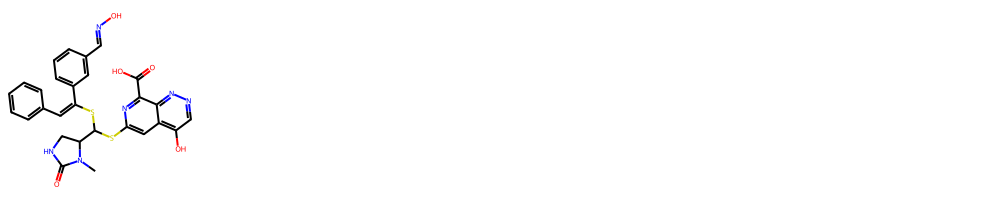

In [26]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [25]:
print(f'Sampled SMILES:\n {t_smiles}')

NameError: ignored

In [29]:
# create a for loop to generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(10):
#for i in range(latent_space.shape[0] - 1):
  latent_seed = latent_space[i:i+1]
  sampling_temp = rn.uniform(0.75, 1.26)
  scale = 0.75
  quantity = 20
  # quantity = 50
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

1/1 [==============================] - 0s 34ms/step


[05:22:26] SMILES Parse Error: extra close parentheses while parsing: C=CC12Oc3ccc(Cl)s3)c3c2n1CCC1CCc2c-3cc(ncc3n(C)c2OCc2c(nc(C)n(C)c3OC)C(=O)C=CC=C2N(C)C(=O)NC1C
[05:22:26] SMILES Parse Error: Failed parsing SMILES 'C=CC12Oc3ccc(Cl)s3)c3c2n1CCC1CCc2c-3cc(ncc3n(C)c2OCc2c(nc(C)n(C)c3OC)C(=O)C=CC=C2N(C)C(=O)NC1C' for input: 'C=CC12Oc3ccc(Cl)s3)c3c2n1CCC1CCc2c-3cc(ncc3n(C)c2OCc2c(nc(C)n(C)c3OC)C(=O)C=CC=C2N(C)C(=O)NC1C'


1/1 [==============================] - 0s 19ms/step


[05:22:33] SMILES Parse Error: extra open parentheses for input: 'Nc1cc2cc(c1=O)CCc1ccnc3sc(C(c4cccc(CCCO[n+](C[n+](Cc5cnn(C(=O)O5)c5)O4)nn2)C(=O)NC1=O)C(F)C3'


1/1 [==============================] - 0s 23ms/step


KeyboardInterrupt: ignored

In [ ]:
# save the generated smiles list
outfile = '/content/generated_smiles_nextgen_v1.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')